In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
structures = pd.read_csv('../data/coordonnees-des-structures-dgfip.csv' ,sep=";")

# Variables disponibles

In [3]:
structures.columns

Index(['Nomenclature interne', 'TYPE DE SERVICE', 'LIBELLE DU SERVICE',
       'NOM DU SERVICE', 'DEPARTEMENT', 'ADRESSE', 'BP', 'CODE POSTAL',
       'COMMUNE', 'CODE COMMUNE', 'COURRIEL', 'HORAIRES 1', 'ACCUEIL SUR RDV',
       'geocodage', 'Type de démarche', 'TELEPHONE 1', 'TELEPHONE 2',
       'Nom Officiel Département', 'Code Officiel Région',
       'Nom Officiel Région', 'public', 'service', 'Code Courant Officiel',
       'Nom Officiel Commune', 'dep_code_de_geocodage'],
      dtype='object')

# Horaires

In [42]:

structures['HORAIRES 1']

0                               SANS RDV L MA J V 8H30-12H
1                                        SEULEMENT SUR RDV
2                                          TLJ  8H45-12H45
3                                TOUS LES MATINS  8H30-12H
4                              DU LUNDI AU VENDREDI 9H-12H
                               ...                        
17827    Voir sur le site https://agence-cohesion-terri...
17828    Voir sur le site https://agence-cohesion-terri...
17829                                  Mercredi 8H30 12H00
17830                                 Mercredi\n8H30 11H30
17831                                    Vendredi 8H30 12H
Name: HORAIRES 1, Length: 17832, dtype: object

<AxesSubplot:>

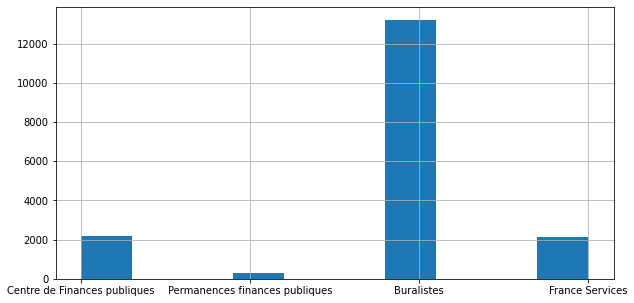

In [4]:
structures['TYPE DE SERVICE'].hist(figsize=(10,5))

In [113]:
# fond de carte des départements
dep = gpd.read_file('https://github.com/gregoiredavid/france-geojson/raw/master/departements-version-simplifiee.geojson', crs='4236')

Text(0.5, 1.0, 'Nombre de centres des finances par département')

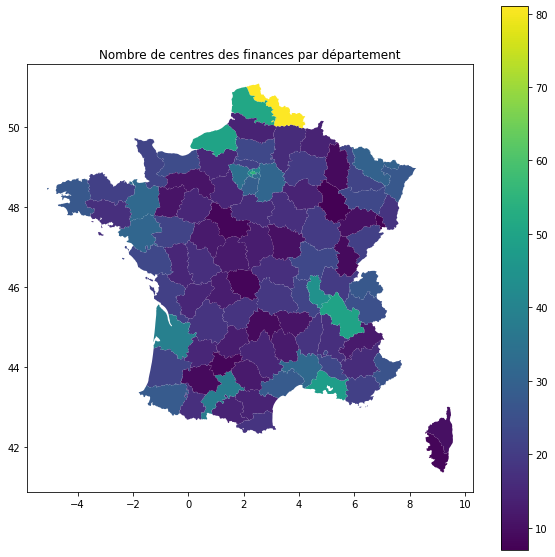

In [6]:
count = structures[structures['TYPE DE SERVICE'] == 'Centre de Finances publiques'].groupby('DEPARTEMENT', as_index=False).size()
ax= dep.merge(count, left_on = 'code', right_on = 'DEPARTEMENT').plot('size', legend=True, figsize=(10,10),)
ax.set_title('Nombre de centres des finances par département')

In [7]:
# import de la population française
population = pd.read_csv('../data/ensemble/Departements.csv', sep=";")

In [8]:
count_norm = count.merge(population, left_on='DEPARTEMENT', right_on="CODDEP")
count_norm['par_hab'] = count_norm['size']/count_norm['PTOT']*10000

Text(0.5, 1.0, 'Nombre de centres des finances  pour 10 000 habitants')

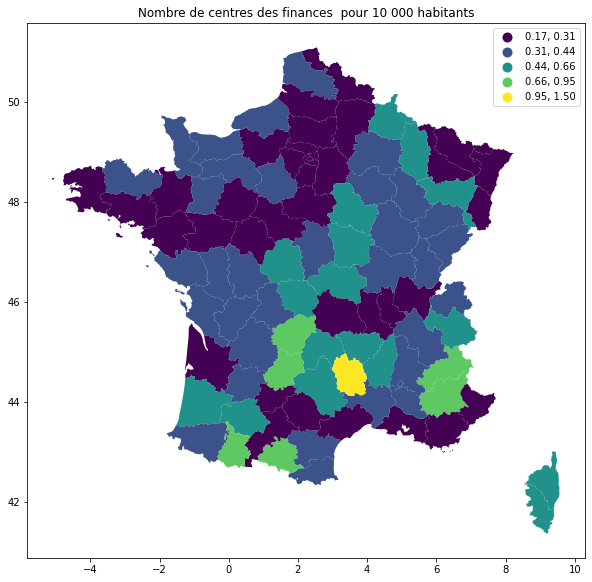

In [9]:
ax= dep.merge(count_norm, left_on = 'code', right_on = 'DEPARTEMENT').plot('par_hab', legend=True, figsize=(10,10), scheme='FisherJenks')
ax.set_title('Nombre de centres des finances  pour 10 000 habitants')

# Géocodage

In [10]:
from collections import Counter
ct = Counter(structures['geocodage'].apply(type))
ct.most_common()

[(str, 17645), (float, 187)]

In [11]:
# exemple structures mal géocodées
pb_geo = structures[structures.geocodage.apply(lambda s : isinstance(s, float))]

<AxesSubplot:>

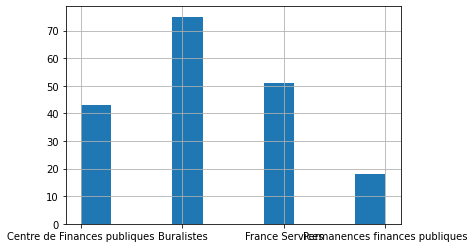

In [12]:
# quels types de structure ?
pb_geo['TYPE DE SERVICE'].hist()

In [13]:
from shapely.geometry import Point
def extract_coord(coords):
    lon, lat = coords.split(',')
    return Point(float(lat), float(lon))

In [14]:
# localisation par type de structure
geo_struct = structures[structures.geocodage.str.contains(',', na=False) & (structures['TYPE DE SERVICE'] != 'Buralistes') & (structures['DEPARTEMENT'].str.len()==2) ]
geo_struct = geo_struct.assign(geometry =  geo_struct.geocodage.apply(extract_coord))
geo_struct = gpd.GeoDataFrame(geo_struct, crs='4326')

<AxesSubplot:>

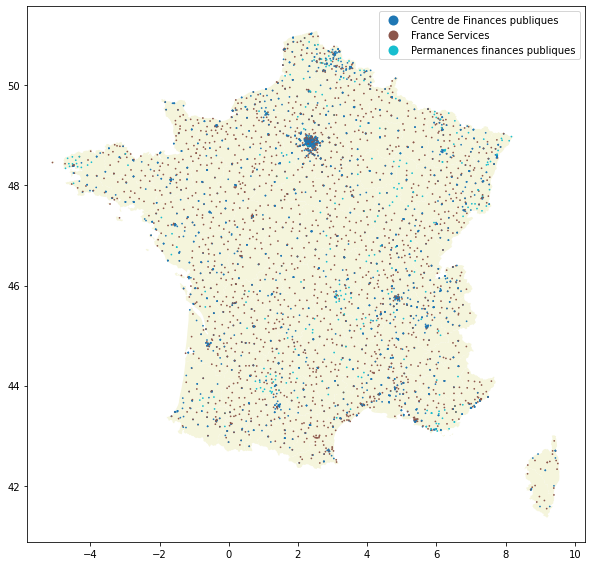

In [15]:
ax = dep.plot(color='beige', figsize=(10,10))
geo_struct.clip(dep).plot(ax= ax, categorical = True, column='TYPE DE SERVICE', legend=True, markersize =0.5)

<AxesSubplot:>

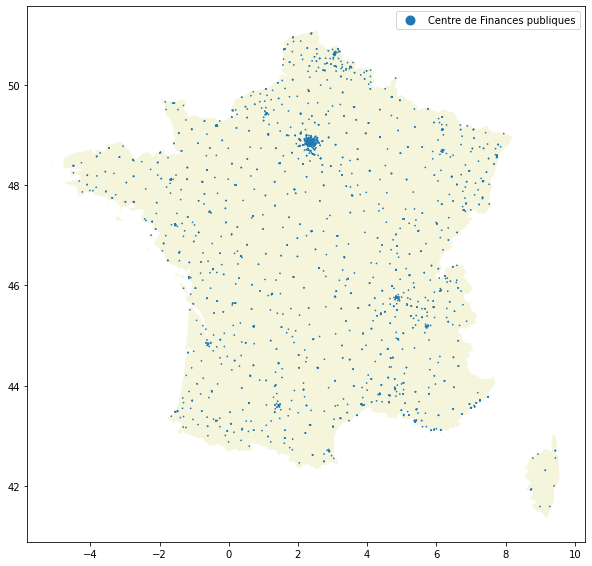

In [16]:
centres = geo_struct[geo_struct['TYPE DE SERVICE'] == 'Centre de Finances publiques']
ax = dep.plot(color='beige', figsize=(10,10))
centres.clip(dep).plot(ax= ax, categorical = True, column='TYPE DE SERVICE', legend=True, markersize =0.5)

kernel approach

# Zone d'influence Bretagne

In [50]:
# localisation par type de structure
#geo_struct_finist = geo_struct[geo_struct['DEPARTEMENT'] == '29']
geo_struct_finist = centres

In [51]:
import numpy as np
x= np.array(geo_struct_finist.to_crs(crs='2154').geometry.x)
y= np.array(geo_struct_finist.to_crs(crs='2154').geometry.y)
points = np.stack((x,y), axis=-1)

In [77]:
# Voronoi
from libpysal.cg.voronoi  import voronoi, voronoi_frames
from scipy.spatial import Voronoi
points_u, index = np.unique(points, axis=0, return_index=True)
region_df, point_df = voronoi_frames(points_u)

In [80]:
points_u.shape

(1312, 2)

<AxesSubplot:>

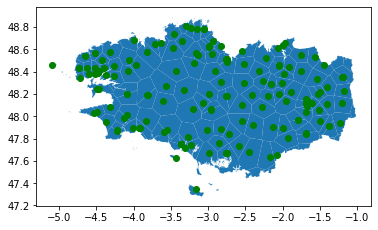

In [43]:
bretagne = gpd.read_file('https://github.com/gregoiredavid/france-geojson/raw/master/regions/bretagne/arrondissements-bretagne.geojson', crs='4326')
ax = region_df.set_crs('2154').to_crs('4326').clip(bretagne).plot()
point_df.set_crs('2154').to_crs('4326').clip(bretagne).plot(ax=ax, color='green')

## Underdeserved areas

In [81]:
x= np.array(centres.to_crs(crs='2154').geometry.x)
y= np.array(centres.to_crs(crs='2154').geometry.y)
points = np.stack((x,y), axis=-1)

In [161]:
points_u, index = np.unique(points, axis=0, return_index=True)
region_df, point_df = voronoi_frames(points_u, clip = box(*dep.to_crs('2154').total_bounds))

<AxesSubplot:>

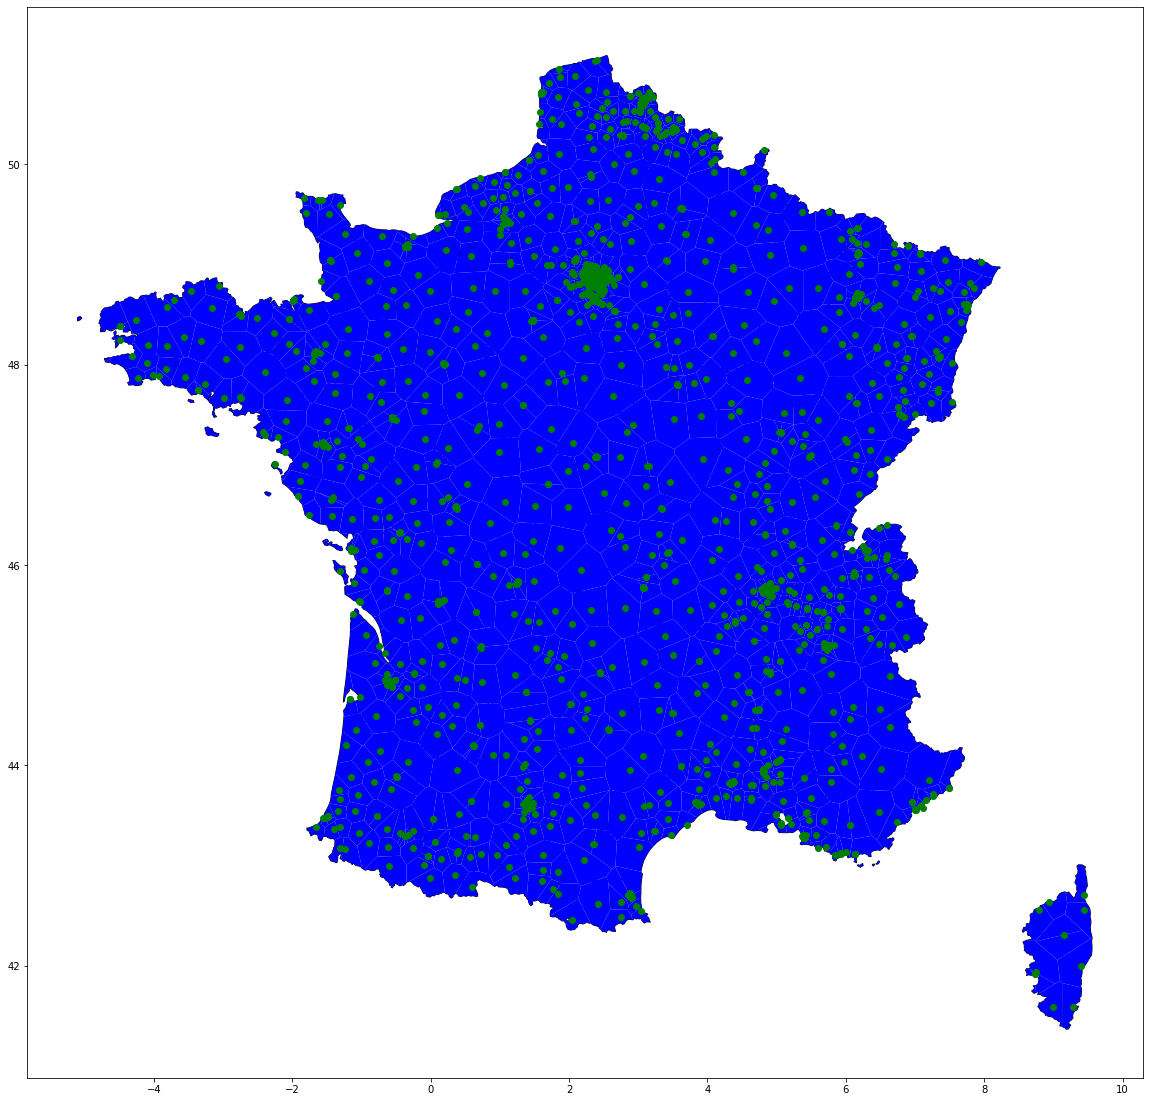

In [191]:
ax = dep.plot(facecolor='beige', edgecolor='black', figsize=(20,20))
region_df.set_crs('2154').to_crs('4326').clip(dep).plot(ax=ax, color='blue', linewidth=1)
point_df.set_crs('2154').to_crs('4326').clip(dep).plot(ax=ax, color='green')

In [168]:
areas = region_df.set_crs("2154").clip(dep.to_crs('2154')).area

In [186]:
large = areas > np.quantile(areas, 0.95)

<AxesSubplot:>

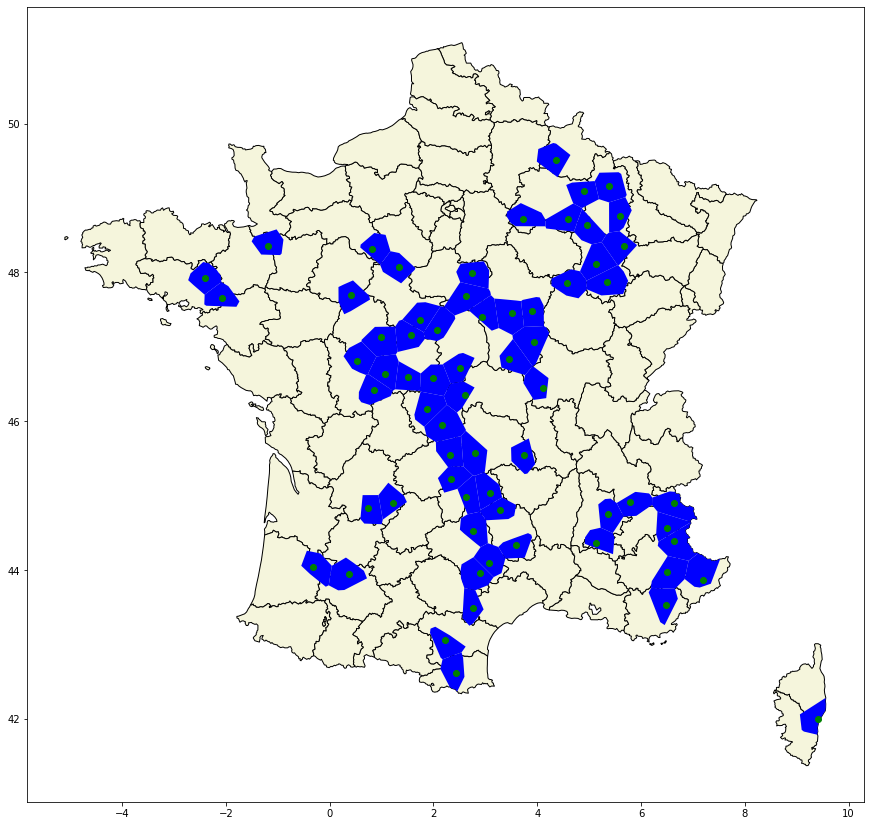

In [192]:
ax = dep.plot(facecolor='beige', edgecolor='black', figsize=(15,15))
region_df.loc[large].set_crs('2154').to_crs('4326').clip(dep).plot(ax=ax, color='blue')
point_df.loc[large].set_crs('2154').to_crs('4326').clip(dep).plot(ax=ax, color='green')

# Types de démarches

In [ ]:
ct = Counter()
for demarches in structures['Type de démarche']:
    ct.update(demarches.replace(">","").split('\n'))
ct.most_common(10)

[(' Paiement des impôts en espèces et CB dans la limite de 300 euros (pour les professionnels, paiement de la CFE uniquement)',
  13211),
 (' Paiement des  amendes, factures locales et hospitalières en espèces dans la limite de 300 euros ou par CB',
  13211),
 (' organisation de RDV avec mon service gestionnaire', 2421),
 (' information générale sur mes impôts et factures,', 2419),
 (' accompagnement et orientation dans mes démarches ', 2419),
 (' accompagnement, dans mes paiements en ligne', 2419),
 (' Effectuer une démarche,', 1630),
 (' Obtenir un renseignement sur mes impôts et factures,', 1613),
 ('(les questions portant sur le montant à payer relèvent des collectivités)',
  1075),
 (' Payer mes factures locales,', 1070)]

In [ ]:
bret = structures[structures.public.str.contains('particuliers', na=False) & structures.DEPARTEMENT.str.slice(0,2).isin({'29','35','56'}) & (structures['TYPE DE SERVICE'] == "Centre de Finances publiques")]